# Предсказание стоимости автомобиля

Для сервиса по продаже поддержаных автомобилей необходимо предсказать их рыночную стоимость.
Обучить модель необходимо на исторических данных.

При выборе оптимальной модели нужно ориантироваться на качество и время обучения и предсказания.

## План выполнения работы:
### <a href=#1>1. Подготовка данных</a>
-     <a href=#1_1> 1.1 Изучение данных</a>
-     <a href=#1_2> 1.2 Обработка пропусков</a>
-     <a href=#1_3> 1.3 Обработка категориальных признаков</a>

### <a href=#2>2. Обучение моделей</a>
-     <a href=#2_0> 2.0 Подготовка выборок</a>
-     <a href=#2_1> 2.1 RandomForestRegressor</a>
-     <a href=#2_2> 2.2 GradientBoostingRegressor</a>
-     <a href=#2_3> 2.3 LightGBM</a>
-     <a href=#2_4> 2.4 CatBoostRegressor</a>
-     <a href=#2_5> 2.5 XGboost</a>

### <a href=#3>3. Оценка качества</a>
### <a href=#4>4. Вывод</a>

# <a id='1'> 1. Подготовка данных</a> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

In [2]:
autos = pd.read_csv('/datasets/autos.csv')

## <a id='1_1'> 1.1 Изучение данных</a> 

In [3]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
def percent_nan(data):
    isna_data = pd.DataFrame(data.isna().sum())
    isna_data.columns = ['nan']
    isna_data['rate'] = isna_data['nan']/len(data)
    return(isna_data.style.format("{:.2%}", subset='rate'))

In [6]:
percent_nan(autos)

,nan,rate
DateCrawled,0,0.00%
Price,0,0.00%
VehicleType,37490,10.58%
RegistrationYear,0,0.00%
Gearbox,19833,5.60%
Power,0,0.00%
Model,19705,5.56%
Kilometer,0,0.00%
RegistrationMonth,0,0.00%
FuelType,32895,9.28%


**Вывод:**
- целевой признак в столбце `Price`;
- категориальные признаки находятся в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`;
- признаки типа дата/время находятся в столбцах `DateCrawled`, `LastSeen`;
- в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` присутствуют пропуски, которые необходимо обработать.
- признаки `DateCrawled` и `LastSeen` скорее всего, не информативны. Удалим их.

## <a id='1_2'>1.2 Обработка пропусков</a> 

- В зависимых столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` есть пропуски. Посмотрим есть ли зависимость в них. Попробуем заменить пропуски на значения из близких категорий.
- Пропуски в столбце `NotRepaired` заменим на значение "no"
- Пропуски в столбце `Model` попробуем удалить.

In [7]:
autos.loc[:,'NotRepaired'] = autos.loc[:,'NotRepaired'].fillna('no')

In [8]:
print('Данных с пропусками во всех столбцах')
print(len(autos.loc[autos['VehicleType'].isna() & autos['Gearbox'].isna() 
                    & autos['Model'].isna() & autos['FuelType'].isna()]))

print('Данных с пропусками в столбцах VehicleType, Model')
print(len(autos.loc[autos['VehicleType'].isna() & autos['Model'].isna()]))

print('Данных с пропусками в столбцах Gearbox, Model')
print(len(autos.loc[autos['Gearbox'].isna() & autos['Model'].isna()]))

print('Данных с пропусками в столбцах FuelType, Model')
print(len(autos.loc[autos['FuelType'].isna() & autos['Model'].isna()]))


Данных с пропусками во всех столбцах
2392
Данных с пропусками в столбцах VehicleType, Model
6828
Данных с пропусками в столбцах Gearbox, Model
4131
Данных с пропусками в столбцах FuelType, Model
7163


Предположим, что у одной и той же модели автомобиля должны быть одинаковые значения параметров VehicleType, Gearbox и FuelType. Заменим пропуски, где это возможно, согласно нашему предположению.

In [9]:
def replace_nan(column):
    model_type = autos.loc[:,('Brand', 'Model', column)].dropna(axis=0).groupby(['Brand',
                                                             'Model'])[column].agg(['first'])
    model_type.set_axis([column], axis='columns', inplace=True)
    for brand, model in model_type.index:
        autos.loc[(autos['Brand']==brand) & (autos['Model']==model), 
                  column]=autos.loc[(autos['Brand']==brand) & (autos['Model']==model),
                                           column].fillna(model_type.loc[(brand, model), column])


In [10]:
replace_nan('VehicleType')
replace_nan('Gearbox')
replace_nan('FuelType')

In [11]:
percent_nan(autos.loc[:,['VehicleType','Gearbox','FuelType']])

,nan,rate
VehicleType,6828,1.93%
Gearbox,4131,1.17%
FuelType,7163,2.02%


Количество пропусков уменьшилось.

In [12]:
autos = autos.dropna(axis=0, subset=['Model'])

In [13]:
percent_nan(autos)

,nan,rate
DateCrawled,0,0.00%
Price,0,0.00%
VehicleType,0,0.00%
RegistrationYear,0,0.00%
Gearbox,0,0.00%
Power,0,0.00%
Model,0,0.00%
Kilometer,0,0.00%
RegistrationMonth,0,0.00%
FuelType,0,0.00%


## <a id='1_3'>1.3 Обработка категориальных признаков</a> 

Если для модели CatBoost нет необходимости как-то обрабатывать категориальные признаки, то для XGBoost нужно переводить все данные типа object в числовые значения. 
- категориальные признаки находятся в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`. Их мы закодируем c помощью LabelEncoder.
- значения в столбце `NotRepaired` переведём в значения (0,1)
- удалим из выборки признаки `DateCrawled` и `LastSeen`

In [14]:
autos = autos.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)

In [15]:
#кодирование бинарного признака
autos['NotRepaired'] = autos['NotRepaired'].map({'no': 0, 'yes': 1})

In [16]:
#кодирование категориальных признаков в числовые значения
def get_encode(data, columns):
    encode_autos = data.copy()
    enc = OrdinalEncoder()
    encode_autos[columns]=enc.fit_transform(encode_autos[columns])
    encode_autos[columns] = encode_autos[columns].astype('int')
    display(encode_autos.head())
    return encode_autos

In [17]:
encode_autos = get_encode(autos, ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand'])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,NumberOfPictures,PostalCode
0,480,5,1993,1,0,116,150000,0,6,37,0,0,70435
2,9800,6,2004,0,163,117,125000,8,2,14,0,0,90480
3,1500,5,2001,1,75,116,150000,6,6,37,0,0,91074
4,3600,5,2008,1,69,101,90000,7,2,31,0,0,60437
5,650,4,1995,1,102,11,150000,10,6,2,1,0,33775


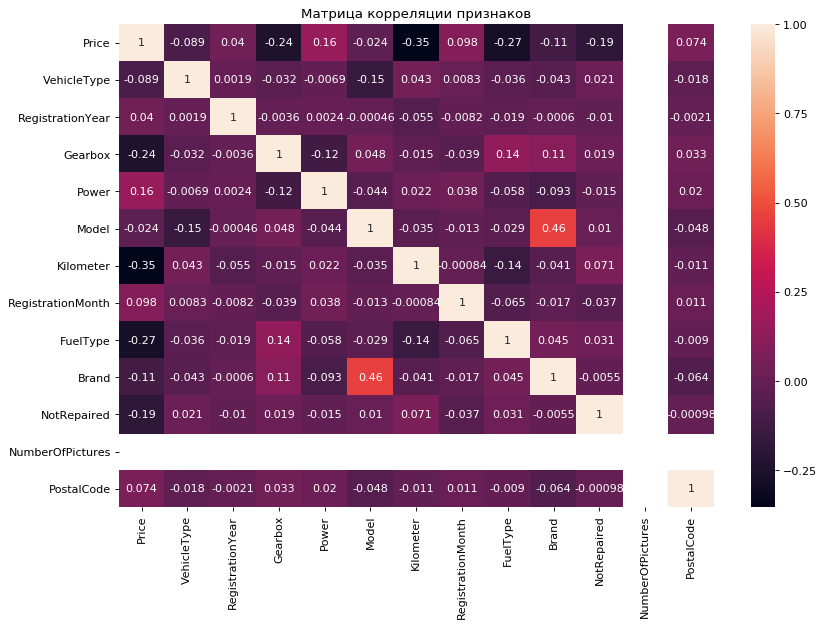

In [18]:
corrMatrix = encode_autos.corr()
f, ax = plt.subplots(figsize=(12, 8), dpi= 80)
plt.title('Матрица корреляции признаков')
sns.heatmap(corrMatrix, annot=True)
plt.show()

Высокая корреляция между признаками `Brand` и `Model`. Имеет смысл заменить их на один общий признак.

In [19]:
autos['Brand_Model']=autos['Brand'] +'_'+ autos['Model']
autos=autos.drop(['Brand','Model'],  axis=1)
autos.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,NotRepaired,NumberOfPictures,PostalCode,Brand_Model
0,480,small,1993,manual,0,150000,0,petrol,0,0,70435,volkswagen_golf
2,9800,suv,2004,auto,163,125000,8,gasoline,0,0,90480,jeep_grand
3,1500,small,2001,manual,75,150000,6,petrol,0,0,91074,volkswagen_golf


In [20]:
encode_autos = get_encode(autos, ['VehicleType', 'Gearbox', 'FuelType', 'Brand_Model'])


,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,NotRepaired,NumberOfPictures,PostalCode,Brand_Model
0,480,5,1993,1,0,150000,0,6,0,0,70435,273
2,9800,6,2004,0,163,125000,8,2,0,0,90480,105
3,1500,5,2001,1,75,150000,6,6,0,0,91074,273
4,3600,5,2008,1,69,90000,7,2,0,0,60437,237
5,650,4,1995,1,102,150000,10,6,1,0,33775,23


In [21]:
encode_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 12 columns):
Price                334664 non-null int64
VehicleType          334664 non-null int64
RegistrationYear     334664 non-null int64
Gearbox              334664 non-null int64
Power                334664 non-null int64
Kilometer            334664 non-null int64
RegistrationMonth    334664 non-null int64
FuelType             334664 non-null int64
NotRepaired          334664 non-null int64
NumberOfPictures     334664 non-null int64
PostalCode           334664 non-null int64
Brand_Model          334664 non-null int64
dtypes: int64(12)
memory usage: 33.2 MB


# <a id='2'>2. Обучение моделей</a> 

## <a id='2_0'>2.0 Подготовка выборок</a> 

Разделим выборку на **features** и **target** части. Подготовим функцию для предсказаний модели и проверки качества. Для оценки качества используем метрику **RMSE**.

In [22]:
target = autos.loc[:,'Price']
features = autos.drop('Price', axis=1)
features_encod = encode_autos.drop('Price', axis=1) #признаки для XGBoost

In [23]:
#разбиение выборок на тренировочную и тестовую части
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=42)
features_encod_train = features_encod.loc[features_train.index,:]
features_encod_test = features_encod.loc[features_test.index,:]

In [24]:
print('Размеры обучающей выборки', features_train.shape,features_encod_train.shape, target_train.shape)
print('Размеры валидационной выборки', features_test.shape,features_encod_test.shape, target_test.shape)


Размеры обучающей выборки (250998, 11) (250998, 11) (250998,)
Размеры валидационной выборки (83666, 11) (83666, 11) (83666,)


In [25]:
#функция для предсказаний и вычисления метрики качества
def get_rmse(model, X_test, y_test):
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    print('MSE: {:.4f}'.format(score))
    return score

In [26]:
my_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [27]:
def get_best_params(features, target, model, parameters):

    #Подберём лучшие параметры модели с помощью RandomizedSearchCV
    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = parameters,
                             scoring=my_scorer, cv = 5,
                             random_state = 124)
    search = clf.fit(features, target)
    print('Best Params: ', search.best_params_)

In [28]:
time_fit = [] #сюда будем записывть время обучения
time_predict = [] #а сюда время предсказания
rmse = [] #метрика качества
models = ['RandomForest', 'GradientBoosting', 'LightGBM', 'CatBoost', 'XGboost']

## <a id='2_1'>2.1 RandomForestRegressor</a> 

In [29]:
parameters ={'max_depth':np.arange(1, 11), 
             'n_estimators':np.arange(10, 50, 5)}
rand_forest = RandomForestRegressor(random_state=124)
get_best_params(features_encod_train, target_train, rand_forest, parameters)

Best Params:  {'n_estimators': 15, 'max_depth': 10}


In [30]:
%%time
rand_forest = RandomForestRegressor(n_estimators=15,
                                    max_depth=10, 
                                    random_state=42).fit(features_encod_train, target_train)

CPU times: user 8.54 s, sys: 22 µs, total: 8.54 s
Wall time: 8.55 s


In [31]:
time_fit.append(8.54)

**Найдём предсказания модели**

In [32]:
%%time
rf_rmse = get_rmse(rand_forest, features_encod_test, target_test)

MSE: 4046559.1106
CPU times: user 128 ms, sys: 3.95 ms, total: 132 ms
Wall time: 135 ms


In [33]:
time_predict.append(0.000156)
rmse.append(np.sqrt(rf_rmse))

## <a id='2_2'>2.2 GradientBoostingRegressor</a> 

In [34]:
#parameters = {'learning_rate': np.arange(0.2, 0.6, 0.1),
#              'n_estimators':np.arange(50, 100, 20)}
#g_boost = GradientBoostingRegressor(max_depth=10, random_state=42)
#get_best_params(features_encod_train, target_train, 
#                g_boost, parameters)

In [35]:
%%time
g_boost = GradientBoostingRegressor(max_depth=10,
                                    n_estimators=70,
                                    learning_rate=0.2,
                                    random_state=42).fit(features_encod_train, target_train)

CPU times: user 4min 18s, sys: 35.8 ms, total: 4min 18s
Wall time: 4min 22s


In [36]:
time_fit.append(263)

In [37]:
%%time
gb_rmse = get_rmse(g_boost, features_encod_test, target_test)

MSE: 2832791.0121
CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 378 ms


In [38]:
time_predict.append(0.000397)
rmse.append(np.sqrt(gb_rmse))

## <a id='2_3'>2.3 LightGBM</a> 

In [39]:
##данные для lightGBM
#lgb_train = lgb.Dataset(features_encod_train, target_train)
#lgb_eval = lgb.Dataset(features_encod_test, target_test, reference=lgb_train)

In [40]:
#%%time
#params = {'num_leaves': 31, 
#         'objective': 'regression',
#         'learning_rate': 0.05, 
#         'metric': 'rmse'}
#lgbm = lgb.train(params,
#                lgb_train,
#                num_boost_round=10,
#                valid_sets=lgb_eval,
#                early_stopping_rounds=5)

In [41]:
%%time
lgbm = lgb.LGBMRegressor(max_depth=10, 
                         learning_rate=0.2, 
                         n_estimators=100, 
                         random_state=42).fit(features_encod_train, target_train)

CPU times: user 7.87 s, sys: 56.9 ms, total: 7.93 s
Wall time: 7.99 s


In [42]:
time_fit.append(10.9)

In [43]:
%%time
lgbm_rmse = get_rmse(lgbm, features_encod_test, target_test)

MSE: 3168212.7975
CPU times: user 735 ms, sys: 0 ns, total: 735 ms
Wall time: 783 ms


In [44]:
time_predict.append(0.000782)
rmse.append(np.sqrt(lgbm_rmse))

## <a id='2_4'>2.4 CatBoostRegressor</a>

In [45]:
%%time
cat = CatBoostRegressor(max_depth=10,
                        n_estimators=100,
                        learning_rate=0.2,
                        cat_features=['VehicleType', 
                                      'Gearbox', 
                                      'FuelType', 
                                      'NotRepaired', 
                                      'Brand_Model']).fit(features_train, target_train)

0:	learn: 3922.1184418	total: 521ms	remaining: 51.6s
1:	learn: 3464.0629230	total: 1.02s	remaining: 50s
2:	learn: 3111.2634050	total: 1.52s	remaining: 49.1s
3:	learn: 2850.1146316	total: 2.02s	remaining: 48.6s
4:	learn: 2651.3130332	total: 2.42s	remaining: 46s
5:	learn: 2509.9026293	total: 2.92s	remaining: 45.7s
6:	learn: 2404.9363739	total: 3.32s	remaining: 44.1s
7:	learn: 2326.3943030	total: 3.81s	remaining: 43.8s
8:	learn: 2244.1149752	total: 4.22s	remaining: 42.7s
9:	learn: 2187.4475627	total: 4.71s	remaining: 42.4s
10:	learn: 2143.4028984	total: 5.12s	remaining: 41.4s
11:	learn: 2109.9284200	total: 5.61s	remaining: 41.1s
12:	learn: 2082.8195037	total: 6.01s	remaining: 40.3s
13:	learn: 2063.7539622	total: 6.51s	remaining: 40s
14:	learn: 2043.6097269	total: 6.91s	remaining: 39.2s
15:	learn: 2030.1549567	total: 7.4s	remaining: 38.9s
16:	learn: 2018.2389437	total: 7.83s	remaining: 38.2s
17:	learn: 1994.3613910	total: 8.33s	remaining: 38s
18:	learn: 1978.1558122	total: 8.71s	remaining:

In [46]:
time_fit.append(47.4)

In [47]:
%%time
cat_rmse = get_rmse(cat, features_test, target_test)

MSE: 3263827.5783
CPU times: user 256 ms, sys: 19.8 ms, total: 276 ms
Wall time: 229 ms


In [48]:
time_predict.append(0.000243)
rmse.append(np.sqrt(cat_rmse))

## <a id='2_5'> 2.5 XGboost</a>

In [49]:
%%time
xgbr = xgb.XGBRegressor(n_estimators=100,
                        max_depth=10,
                        learning_rate=0.2).fit(features_encod_train, target_train)

/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[07:53:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 59.8 s, sys: 73.8 ms, total: 59.9 s
Wall time: 1min


In [50]:
time_fit.append(60)

In [51]:
%%time
xgbr_rmse = get_rmse(xgbr, features_encod_test, target_test)

MSE: 2776934.3472
CPU times: user 1.22 s, sys: 0 ns, total: 1.22 s
Wall time: 1.24 s


In [52]:
time_predict.append(1.23)
rmse.append(np.sqrt(xgbr_rmse))

# 3. Анализ моделей

In [53]:
models_score = pd.DataFrame(data=time_fit, index=models, columns=['time_fit'])
models_score['time_predict'] = time_predict
models_score['RMSE'] = rmse

In [54]:
models_score

,time_fit,time_predict,RMSE
RandomForest,8.54,0.000156,2011.606102
GradientBoosting,263.00,0.000397,1683.089722
LightGBM,10.90,0.000782,1779.947414
CatBoost,47.40,0.000243,1806.606647
XGboost,60.00,1.230000,1666.413618


In [55]:
models_score = models_score.reset_index(drop=False)
models_score.set_axis(['models', 'time_fit', 'time_predict', 'RMSE'], axis='columns', inplace=True)
models_score = models_score.sort_values('RMSE')

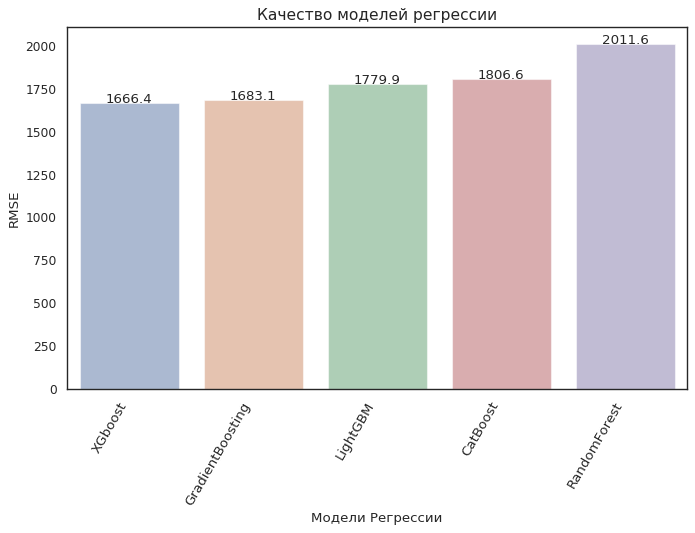

In [56]:
sns.set(style="white", palette="deep", color_codes=True)
fig, ax = plt.subplots(figsize=(10,6), dpi= 80)
plt.title('Качество моделей регрессии', fontdict={'fontsize':14})

ax=sns.barplot(x='models', y='RMSE', palette="deep", data=models_score, alpha=.5)
for i, rmse in enumerate(models_score.RMSE):
    ax.text(i, rmse+0.5, round(rmse, 1), horizontalalignment='center')
ax.set_xlabel('Модели Регрессии')
ax.set_ylabel('RMSE')
plt.xticks( rotation=60, horizontalalignment='right', fontsize=12)
plt.show()

### Вывод:
- Лучшее качество показывает модель **XGBoost**, но время обучение и время предсказания у неё выше, чем у других моделей (за исключением **GradientBoostingRegressor**, который обучается очень долго)
- Быстрее всех обучалась модель RandomForestRegressor, Но качество у неё самое низкое. 